<a href="https://colab.research.google.com/github/alouwyck/vives-machine-learning/blob/main/13_recommender_systems/2_association_rule_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

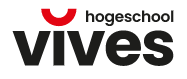<br>


**MACHINE LEARNING FUNDAMENTALS**<br>
Academiejaar 2023-2024<br>
Andy Louwyck

---



---



# ASSOCIATION RULE LEARNING: THEORIE

## Inleiding

**Association rule learning:**
- = assocation rule mining
- = rule-based machine learning methode
- unsupervised learning (hoewel hier discussie over is...)
- toegepast in data mining: relaties tussen gegevens ontdekken in grote databanken

**Voorbeelden:**
- Market basket analysis (=Affinity analysis):

> associatieregel `{frieten, uien} => {hamburgers}`: klant die frieten en uien koopt, zal *waarschijnlijk* ook hamburgers kopen

- The "beer and diaper" story:

> "In 1992, Thomas Blischok, manager of a retail consulting group at Teradata, and his staff prepared an analysis of 1.2 million market baskets from about 25 Osco Drug stores. Database queries were developed to identify affinities. The analysis did discover that between 5:00 and 7:00 p.m. that consumers bought beer and diapers."

- Suggesties in webshops:

> 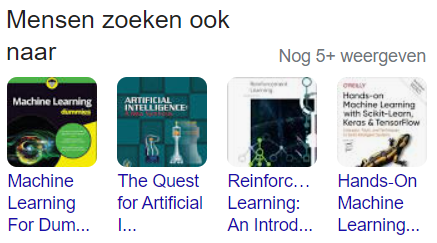

- Information bubble:

> "Omdat er gekeken wordt naar vaak voorkomende combinaties zullen we op Facebook, bijvoorbeeld, vooral artikelen zien verschijnen waarvan de inhoud overeenkomt met wat we eerder hebben gelezen. De algoritmes gaan
namelijk na welke andere links andere gebruikers hebben aangeklikt in combinatie met de links waarop wij klikken. Als een Amerikaan een artikel van het conservatieve Fox News leest, is de kans zeer reëel dat hij/zij daarna artikelen van de alt-right krant Breitbart te zien zal krijgen. Men spreekt in dat verband van de “information bubble” waarin we zitten. Omdat we nooit informatie van een andere strekking krijgen te zien, krijgen we een eenzijdig beeld op de zaken die ons bezighouden."

**Algoritmes:**
- Apriori
- FP-growth
- Eclat
- ...

Wij bespreken enkel de eerste twee, die beschikbaar zijn in de recentere versies van de `mlxtend` library: http://rasbt.github.io/mlxtend/.

We installeren versie 0.18.0:



In [ ]:
!pip install mlxtend=='0.18.0'

Versie controleren:

In [ ]:
import mlxtend
print(mlxtend.__version__)

0.18.0


## Association Rules

### Terminologie

**Transactie**
- Engels: transaction
- Een aantal samenhangende acties in een database, die ofwel allemaal ofwel geen van allen worden uitgevoerd
- Bijvoorbeelden:
  - een reeks bezochte pagina's op een website
  - een online verkoop met
daarin een combinatie van aangekochte artikelen
  - een luistersessie waarin een gebruiker meerdere
songs selecteert op een streaming muziekdienst

**Item**
- een artikel, een element, ...
- voorbeelden:
  - een bezochte pagina
  - een aangekocht product
  - een beluisterde song

**Itemset**
- ongeordende verzameling van items
- voorbeeld: `{frieten, hamburgers}`

**Association rule**
- een regel die twee itemsets met elkaar associeert
- in feite een logische implicatie voorgesteld door `=>`
- met een antecendent (left-hand side LHS) en een consequent (right-hand side RHS)
- voorbeeld: `{frieten, uien} => {hamburgers}`

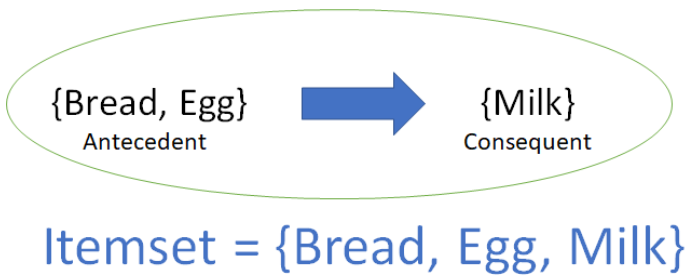

### Association Rules bepalen

2 stappen:
1.   frequenties berekenen van de combinaties van items in een transactie
2.   frequenties gebruiken om de associatieregels vast te leggen

In stap 1 gaan we gebruik maken van de metriek **support**, in stap 2 van de metriek **confidence**.



#### Stap 1: Frequenties berekenen

- we berekenen de relatieve frequentie van de mogelijke combinaties (= itemsets)
- die relatieve frequentie noemen we hier de **support**
- support = aantal keer dat een combinatie voorkomt gedeeld door het aantal transacties
- de support ligt altijd tussen 0 en 1 (grenzen inbegrepen)

Voorbeeld:

Lees "KassaTickets.csv" in:

In [ ]:
import pandas as pd

kassatickets = pd.read_csv("KassaTickets.csv", sep=";")
kassatickets

,KassaTicket,Printer,Papier,Cartridge,Balpen
0,1000123,1,0,1,1
1,1000124,0,1,1,0
2,1000125,0,1,1,0
3,1000126,1,0,1,0
4,1000127,1,0,1,0
5,1000128,0,0,0,1
6,1000129,0,1,1,1
7,1000130,0,0,1,0
8,1000131,1,0,0,1
9,1000132,0,1,0,0


- 10 kassatickets (= transacties)
- 4 mogelijk producten (= items):
  - printer
  - papier
  - cartridge
  - balpen


De support van combinatie `{printer}` is het aantal keer dat printer voorkomt op een kassaticket gedeeld door het totaal aantal kassatickets:

In [ ]:
kassatickets.Printer.sum() / len(kassatickets)

0.4

De support van alle combinaties die slechts uit 1 item bestaan:

In [ ]:
n = len(kassatickets)
for item in kassatickets.columns[1:]:  # eerste kolom is geen item!
    print("support van {", item, "} is ", kassatickets[item].sum() / n, sep="")

support van {Printer} is 0.4
support van {Papier} is 0.4
support van {Cartridge} is 0.7
support van {Balpen} is 0.4


De support van de combinatie `{printer, cartridge}`:

In [ ]:
# printer en cartridge zijn samen gekocht als de som van features "Printer" en "Cartridge" gelijk is aan 2
kassatickets[["Printer", "Cartridge"]].sum(axis=1)

0    2
1    1
2    1
3    2
4    2
5    0
6    1
7    1
8    1
9    0
dtype: int64

In [ ]:
# de support is dus het aantal keren dat die som gelijk is aan 2 gedeeld door n
(kassatickets[["Printer", "Cartridge"]].sum(axis=1) ==  2).sum() / n

0.3

De support van alle combinaties van 2 items:

In [ ]:
# alle mogelijke combinaties bepalen adhv itertools.combinations
from itertools import combinations

for combination in combinations(kassatickets.columns[1:], 2):
    print(combination)  # combination is een tuple

('Printer', 'Papier')
('Printer', 'Cartridge')
('Printer', 'Balpen')
('Papier', 'Cartridge')
('Papier', 'Balpen')
('Cartridge', 'Balpen')


In [ ]:
# de support berekenen van al die combinaties:
k = 2
for item1, item2 in combinations(kassatickets.columns[1:], k):
    support = (kassatickets[[item1, item2]].sum(axis=1) == k).sum() / n
    print("support van {", item1, ", ", item2, "} is ", support, sep="")

support van {Printer, Papier} is 0.0
support van {Printer, Cartridge} is 0.3
support van {Printer, Balpen} is 0.2
support van {Papier, Cartridge} is 0.3
support van {Papier, Balpen} is 0.1
support van {Cartridge, Balpen} is 0.2


De support van alle combinaties van 3 items:

In [ ]:
# de support berekenen van al die combinaties:
k = 3
for item1, item2, item3 in combinations(kassatickets.columns[1:], k):
    support = (kassatickets[[item1, item2, item3]].sum(axis=1) == k).sum() / n
    print("support van {", item1, ", ", item2, ", ", item3, "} is ", support, sep="")

support van {Printer, Papier, Cartridge} is 0.0
support van {Printer, Papier, Balpen} is 0.0
support van {Printer, Cartridge, Balpen} is 0.1
support van {Papier, Cartridge, Balpen} is 0.1


De support van de combinatie die de 4 items bevat:

In [ ]:
(kassatickets.drop(["KassaTicket"], axis=1).sum(axis=1) == 4).sum() / n

0.0

#### Stap 2: Associatieregels vastleggen

- **Confidences** berekenen a.d.h.v. supports
- Confidence van `S1 => S2` = zekerheid dat itemset S2 voorkomt als itemset S1 voorkomt
- Confidence van `S1 => S2` = support van S1 en S2 gedeeld door support van S1
- `Confidence(S1 => S2) = Support(S1 U S2) / Support(S1)`
- de confidence ligt altijd tussen 0 en 1 (grenzen inbegrepen):
  - confidence = 0: associatie komt nooit voor
  - confidence = 1: associatie komt altijd voor

Merk op:
- Support van een associatieregel: `Support(S1 => S2) = Support(S1 U S2)`
- **Coverage** van een associatieregel: `Coverage(S1 => S2) = Support(S1)`
- Dus: `Confidence(S1 => S2) = Support(S1 => S2) / Coverage(S1 => S2)`

Voorbeeld:

`Confidence({printer} => {cartridge}) = Support({printer, cartridge}) / Support({printer}) = 0.3 / 0.4 = 0.75`

In [ ]:
support_printer_cartridge = (kassatickets[["Printer", "Cartridge"]].sum(axis=1) == 2).sum() / n
support_printer = kassatickets.Printer.sum() / n
confidence_printer_cartridge = support_printer_cartridge / support_printer

print("support van {printer, cartridge} is", support_printer_cartridge)
print("support van {printer} is", support_printer)
print("confidence van {printer} => {cartridge} is", confidence_printer_cartridge)

support van {printer, cartridge} is 0.3
support van {printer} is 0.4
confidence van {printer} => {cartridge} is 0.7499999999999999


Hoe associatieregels vastleggen?
- alle regels selecteren met confidence groter dan bepaalde drempel, bijv. 0.1
- de m regels nemen met de hoogste confidence, bijv m = 3 om de drie sterkste regels te selecteren
- meestal wordt ook een drempel voor de support gedefinieerd

Confidence berekenen van alle associatieregels die combinaties met slechts 1 item bevatten:

In [ ]:
items = kassatickets.columns[1:]
n = len(kassatickets)
for item1 in items:
    for item2 in items:
        if item1 != item2:  # als item1 == item2, dan is de confidence altijd gelijk aan 1
            confidence = (kassatickets[[item1, item2]].sum(axis=1) == 2).sum() / kassatickets[item1].sum()
            print("confidence({", item1, "} => {", item2, "}) = ", round(confidence, 3), sep="")

confidence({Printer} => {Papier}) = 0.0
confidence({Printer} => {Cartridge}) = 0.75
confidence({Printer} => {Balpen}) = 0.5
confidence({Papier} => {Printer}) = 0.0
confidence({Papier} => {Cartridge}) = 0.75
confidence({Papier} => {Balpen}) = 0.25
confidence({Cartridge} => {Printer}) = 0.429
confidence({Cartridge} => {Papier}) = 0.429
confidence({Cartridge} => {Balpen}) = 0.286
confidence({Balpen} => {Printer}) = 0.5
confidence({Balpen} => {Papier}) = 0.25
confidence({Balpen} => {Cartridge}) = 0.5


**OPGELET!**<br>
`Confidence(S1 => S2)` is niet gelijk aan `Confidence(S2 => S1)`!

Je kan ook de confidence berekenen voor combinaties met meer dan 1 item:

In [ ]:
# we gaan gebruik maken van Python sets!
S1 = {"Printer", "Balpen"}
S2 = {"Cartridge"}

# unie berekenen
S = S1.union(S2)
S

{'Balpen', 'Cartridge', 'Printer'}

In [ ]:
confidence_S1_S2 = (kassatickets[S].sum(axis=1) == len(S)).sum() / (kassatickets[S1].sum(axis=1) == len(S1)).sum()
print("Confidence van", S1, "=>", S2, "is", confidence_S1_S2)

confidence_S2_S1 = (kassatickets[S].sum(axis=1) == len(S)).sum() / (kassatickets[S2].sum(axis=1) == len(S2)).sum()
print("Confidence van", S2, "=>", S1, "is", confidence_S2_S1)

Confidence van {'Balpen', 'Printer'} => {'Cartridge'} is 0.5
Confidence van {'Cartridge'} => {'Balpen', 'Printer'} is 0.14285714285714285


#### Generieke functies

Metrieken support en confidence kunnen we in generieke functies implementeren:

In [ ]:
def support(df, S):
    # df is dataframe
    # S is an itemset, which is a set with column names
    # returns support(S)
    return (df[S].sum(axis=1) == len(S)).sum() / len(df)


def confidence(df, S1, S2):
    # df is dataframe
    # S1 and S2 are itemsets, which are sets with column names
    # returns confidence(S1 => S2)
    return support(df, S1.union(S2)) / support(df, S1)

En we kunnen ook generieke print functies schrijven:

In [ ]:
def print_support(df, S, ndigits=None):
    # df is dataframe
    # S is an itemset, which is a set with column names
    # ndigits are the number of digits used by function round()
    # prints support(S)
    s = support(df, S)
    if ndigits:
        s = round(s, ndigits)
    print("support(", S, ") = ", s, sep="")

def print_confidence(df, S1, S2, ndigits=None):
    # df is dataframe
    # S1 and S2 are itemsets, which are sets with column names
    # ndigits are the number of digits used by function round()
    # prints confidence(S1 => S2)
    c = confidence(df, S1, S2)
    if ndigits:
        c = round(c, ndigits)
    print("confidence(", S1, " => ", S2, ") = ", c, sep="")

Uittesten:

In [ ]:
print_support(kassatickets, {"Balpen", "Printer", "Cartridge"})
print_support(kassatickets, {"Balpen", "Printer"})
print_confidence(kassatickets, {"Balpen", "Printer"}, {"Cartridge"})
print()
print_support(kassatickets, {"Balpen", "Papier", "Cartridge"})
print_support(kassatickets, {"Papier"})
print_confidence(kassatickets, {"Papier"}, {"Balpen", "Cartridge"})

support({'Cartridge', 'Balpen', 'Printer'}) = 0.1
support({'Balpen', 'Printer'}) = 0.2
confidence({'Balpen', 'Printer'} => {'Cartridge'}) = 0.5

support({'Cartridge', 'Balpen', 'Papier'}) = 0.1
support({'Papier'}) = 0.4
confidence({'Papier'} => {'Cartridge', 'Balpen'}) = 0.25


Confidence van alle associaties tussen alle mogelijke itemsets berekenen:
- voor dit voorbeeld misschien nog mogelijk...
- maar niet voor reële datasets van winkels of webshops of ...

Daarom:
- minimum support en confidence opgeven
- extra metrieken gebruiken (zie volgend punt)
- efficiëntere algoritmes toepassen (zie verder)

### Andere metrieken

Er zijn nog andere metrieken om het nut van een associatieregel na te gaan:
- lift
- leverage
- conviction

#### Lift

We kijken best naar support én confidence, voorbeeld:
- `confidence({balpen} => {cartridge}) = 0.5` wil zeggen dat er 50 % kans is dat de klant een cartridge koopt als er een balpen in het winkelmandje ligt
- `support({cartridge}) = 0.7` wil zeggen dat er 70 % kans is dat de klant een cartridge koopt, onafhankelijk van wat er in het mandje ligt
- we zijn dus minder zeker dat een klant een cartridge zal kopen, ook al ligt er al een balpen in het mandje
- `lift({balpen} => {cartridge}) = confidence({balpen} => {cartridge}) / support({cartridge}) = 0.5 / 0.7 = 0.71`
- lift is kleiner dan 1, dus heeft het weinig zin om de regel vast te leggen

Algemeen:
- de lift van een associatieregel is de confidence van die regel gedeeld door de support van de consequent
- `lift(S1 => S2) = confidence(S1 => S2) / support(S2)` met `S1` en `S2` itemsets
- de lift is een waarde tussen 0 en oneindig (grenzen inbegrepen)
- een regel is pas nuttig als zijn lift groter is dan 1

Generieke functie `lift()` implementeren, en bijhorende print functie:

In [ ]:
def lift(df, S1, S2):
    # df is dataframe
    # S1 and S2 are itemsets, which are sets with column names
    # returns lift(S1 => S2)
    return confidence(df, S1, S2) / support(df, S2)

def print_lift(df, S1, S2, ndigits=None):
    # df is dataframe
    # S1 and S2 are itemsets, which are sets with column names
    # ndigits are the number of digits used by function round()
    # prints lift(S1 => S2)
    lf = lift(df, S1, S2)
    if ndigits:
        lf = round(lf, ndigits)
    print("lift(", S1, " => ", S2, ") = ", lf, sep="")

Uittesten:

In [ ]:
print_lift(kassatickets, {'Balpen'}, {"Cartridge"}, ndigits=3)

lift({'Balpen'} => {'Cartridge'}) = 0.714


Lift berekenen van alle associatieregels die combinaties met slechts 1 item bevatten:

In [ ]:
items = kassatickets.columns[1:]
n = len(kassatickets)
for item1 in items:
    for item2 in items:
        if item1 != item2:
            print_lift(kassatickets, {item1}, {item2}, ndigits=3)

lift({'Printer'} => {'Papier'}) = 0.0
lift({'Printer'} => {'Cartridge'}) = 1.071
lift({'Printer'} => {'Balpen'}) = 1.25
lift({'Papier'} => {'Printer'}) = 0.0
lift({'Papier'} => {'Cartridge'}) = 1.071
lift({'Papier'} => {'Balpen'}) = 0.625
lift({'Cartridge'} => {'Printer'}) = 1.071
lift({'Cartridge'} => {'Papier'}) = 1.071
lift({'Cartridge'} => {'Balpen'}) = 0.714
lift({'Balpen'} => {'Printer'}) = 1.25
lift({'Balpen'} => {'Papier'}) = 0.625
lift({'Balpen'} => {'Cartridge'}) = 0.714


Uiteraard kan je ook de lift berekenen voor combinaties met meer dan 1 item:

In [ ]:
print_lift(kassatickets, {"Balpen", "Printer"}, {"Cartridge"})

lift({'Printer', 'Balpen'} => {'Cartridge'}) = 0.7142857142857143


#### Leverage

- leverage is het verschil tussen de relatieve frequentie van het samen voorkomen van itemsets `S1` en `S2` en de relatieve frequentie die je in dit geval zou krijgen wanneer `S1` en `S2` onafhankelijk zijn
- `leverage(S1 => S2) = support(S1 U S2) - support(S1) * support(S2)`, met `S1` en `S2` itemsets
- leverage is een waarde tussen -1 en 1 (grenzen inbegrepen)
- leverage is 0 als `S1` en `S2` effectief onafhankelijk zijn (en dat willen we niet!)


Generieke functie implementeren:

In [ ]:
def leverage(df, S1, S2):
    # df is dataframe
    # S1 and S2 are itemsets, which are sets with column names
    # returns leverage(S1 => S2)
    return support(df, S1.union(S2)) - support(df, S1) * support(df, S2)

def print_leverage(df, S1, S2, ndigits=None):
    # df is dataframe
    # S1 and S2 are itemsets, which are sets with column names
    # ndigits are the number of digits used by function round()
    # prints leverage(S1 => S2)
    lv = leverage(df, S1, S2)
    if ndigits:
        lv = round(lv, ndigits)
    print("leverage(", S1, " => ", S2, ") = ", lv, sep="")

Leverage berekenen van alle associatieregels die combinaties met slechts 1 item bevatten:

In [ ]:
items = kassatickets.columns[1:]
n = len(kassatickets)
for item1 in items:
    for item2 in items:
        if item1 != item2:
            print_leverage(kassatickets, {item1}, {item2}, ndigits=3)

leverage({'Printer'} => {'Papier'}) = -0.16
leverage({'Printer'} => {'Cartridge'}) = 0.02
leverage({'Printer'} => {'Balpen'}) = 0.04
leverage({'Papier'} => {'Printer'}) = -0.16
leverage({'Papier'} => {'Cartridge'}) = 0.02
leverage({'Papier'} => {'Balpen'}) = -0.06
leverage({'Cartridge'} => {'Printer'}) = 0.02
leverage({'Cartridge'} => {'Papier'}) = 0.02
leverage({'Cartridge'} => {'Balpen'}) = -0.08
leverage({'Balpen'} => {'Printer'}) = 0.04
leverage({'Balpen'} => {'Papier'}) = -0.06
leverage({'Balpen'} => {'Cartridge'}) = -0.08


Merk op dat `leverage(S1 => S2) == leverage(S2 => S1)`

Uiteraard kan je ook de leverage berekenen voor combinaties met meer dan 1 item:

In [ ]:
print_leverage(kassatickets, {"Balpen", "Papier"}, {"Cartridge"}, ndigits=2)

leverage({'Papier', 'Balpen'} => {'Cartridge'}) = 0.03


#### Conviction

- geeft weer hoe sterk de consequent in een associatieregel afhangt van de antecedent
- `conviction(S1 => S2) = (1 - support(S2)) / (1 - confidence(S1 => S2))`, met `S1` en `S2` itemsets
- conviction is een waarde tussen 0 en oneindig (waarden inbegrepen)
- hoe hoger de conviction, hoe meer de consequent afhangt van de antecedent
- wanneer `confidence(S1 => S2)` gelijk is aan 1, dan is de conviction oneindig groot
- net als bij lift is een regel pas nuttig als zijn conviction groter is dan 1

Generieke functie `conviction()` implementeren met bijhorende print functie:

In [ ]:
def conviction(df, S1, S2):
    # df is dataframe
    # S1 and S2 are itemsets, which are sets with column names
    # returns conviction(S1 => S2)
    return (1 - support(df, S2)) / (1 - confidence(df, S1, S2))

def print_conviction(df, S1, S2, ndigits=None):
    # df is dataframe
    # S1 and S2 are itemsets, which are sets with column names
    # ndigits are the number of digits used by function round()
    # prints conviction(S1 => S2)
    c = conviction(df, S1, S2)
    if ndigits:
        c = round(c, ndigits)
    print("conviction(", S1, " => ", S2, ") = ", c, sep="")

Conviction berekenen van alle associatieregels die combinaties met slechts 1 item bevatten:

In [ ]:
items = kassatickets.columns[1:]
n = len(kassatickets)
for item1 in items:
    for item2 in items:
        if item1 != item2:
            print_conviction(kassatickets, {item1}, {item2}, ndigits=3)

conviction({'Printer'} => {'Papier'}) = 0.6
conviction({'Printer'} => {'Cartridge'}) = 1.2
conviction({'Printer'} => {'Balpen'}) = 1.2
conviction({'Papier'} => {'Printer'}) = 0.6
conviction({'Papier'} => {'Cartridge'}) = 1.2
conviction({'Papier'} => {'Balpen'}) = 0.8
conviction({'Cartridge'} => {'Printer'}) = 1.05
conviction({'Cartridge'} => {'Papier'}) = 1.05
conviction({'Cartridge'} => {'Balpen'}) = 0.84
conviction({'Balpen'} => {'Printer'}) = 1.2
conviction({'Balpen'} => {'Papier'}) = 0.8
conviction({'Balpen'} => {'Cartridge'}) = 0.6


Uiteraard kan je ook de leverage berekenen voor combinaties met meer dan 1 item:

In [ ]:
print_conviction(kassatickets, {"Balpen", "Papier"}, {"Cartridge"}, ndigits=2)

conviction({'Papier', 'Balpen'} => {'Cartridge'}) = inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


Doordat we met NumPy werken, krijgen we effectief `inf` als uitkomst, en geen foutmelding omdat we door 0 delen, wel een warning.

#### Samenvatting

Metrieken die we hebben besproken voor het evalueren van association rules, met `S1` en `S2` itemsets:

|Metriek|Formule|Range|Probabiliteit
|:---|:---|:---|:---|
|`support(S1)`|`(# keren dat S1 voorkomt) / (# transacties)`|`[0, 1]`|P(S1)|
|`support(S1 => S2)`|`support(S1 U S2)`|`[0, 1]`|P(S1 en S2)|
|`coverage(S1 => S2)`|`support(S1)`|`[0, 1]`|P(S1)|
|`confidence(S1 => S2)`|`support(S1 => S2) / support(S1)`|`[0, 1]`|P(S2 &#124; S1) = P(S1 en S2) / P(S1)|
|`lift(S1 => S2)`|`confidence(S1 => S2) / support(S2)`|`[0,` $\infty$ `]`|P(S2 &#124; S1) / P(S2)|
|`leverage(S1 => S2)`|`support(S1 U S2) - support(S1) * support(S2)`|`[-1, 1]`|P(S1 en S2) - P(S1).P(S2)|
|`conviction(S1 => S2)`|`(1 - support(S2)) / (1 - confidence(S1 => S2))`|`[0,` $\infty$ `]`|P(S1).P(niet S2) / P(S1 en niet S2)|

De laatste kolom geeft de overeenkomstige **probabiliteit** weer. Hou wel voor ogen dat de metrieken worden berekend a.d.h.v. waargenomen relatieve frequenties, en dus veronderstellen we dat die ons een betrouwbare inschatting geven van de verwachte relatieve frequenties of kansen (zie statistiek: experimentele wet van de grote aantallen).

Zo interpreteren we de support van S1 als P(S1), d.i. de kans dat S1 voorkomt of optreedt, en de confidence van een regel `S1 => S2` als de **voorwaardelijke kans** P(S2 | S1), d.i. de kans dat S2 voorkomt gegeven dat S1 voorkomt. Die kans is gelijk aan P(S1 en S2) / P(S1).

Voorbeeld: `confidence(luiers => bier) = 0.7` interpreteren we als "er is 70 % kans dat een klant bier koopt als er ook al luiers in het winkelmandje liggen".

Bij de leverage herinneren we ons dat de kans op S1 én S2 gelijk is aan de kans op S1 maal de kans op S2 als S1 en S2 onafhankelijk zijn:
> P(S1 en S2) = P(S1).P(S2)

In dat geval is de leverage nul. Onafhankelijke gebeurtenissen zijn gebeurtenissen die geen invloed hebben op elkaar. Als het kopen van luiers en het kopen van bier onafhankelijk zouden zijn, dan zou de leverage dus nul zijn.

Bij conviction is P(niet S2) de kans dat S2 niet voorkomt of optreedt. Deze kans is gelijk aan 1 - P(S2). De voorwaardelijke kans P(niet S2 | S1) is dan de kans dat S2 niet voorkomt gegeven dat S1 wel voorkomt. Die kans is gelijk aan 1 - P(S2 | S1).

### Algoritmes

Om associatieregels vast te kunnen leggen moet de support van mogelijke combinaties berekend worden:
- intuïtief:
  - voor elke mogelijke combinatie alle transacties doorlopen (zie hierboven)
  - niet efficiënt bij (hele) grote databanken
- efficiëntere algoritmes, bijvoorbeeld:
  - Apriori
  - FP-growth
  - gaan uit van een minimum support
  - beiden beschikbaar in `mlxtend`

#### Apriori

##### Werking

0. Definieer minimum support `s`, bijv. 0.2.
1. Start met alle combinaties met één item en bereken de support.
2. Schrap de combinaties met support kleiner dan `s`.
3. Bepaal alle combinaties met twee items en bereken de support.
<br>Items die in stap 2 geschrapt zijn, sla je over.
4. Schrap opnieuw de combinaties met support kleiner dan `s`.
5. Bepaal alle combinaties met drie items en bereken de support.
<br>Combinaties die geschrapte combinaties uit stap 2 of 4 bevatten sla je over.
6. Schrap opnieuw de combinaties met support kleiner dan `s`.
7. Ga zo verder met combinaties van 4 items, 5 items, ...

3 en 5: combinaties die geschrapte items bevatten overslaan omdat:
- `support(S1) >= support(S1 U S2)`
- `support(S2) >= support(S1 U S2)`

Bijvoorbeeld:
- 4 transacties met printer: `support({printer}) = 0.4`
- 7 transacties met cartridge: `support({cartridge}) = 0.7`
- 3 transacties met printer én cartridge: `support({printer, cartridge}) = 0.3`

##### `mlxtend`

*Stap 0*: functies `apriori()` en `association_rules()` importeren uit module `mlxtend.frequent_patterns`:

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

*Stap 1*: functie `apriori()` toepassen om de supports te berekenen:

In [ ]:
frequent_itemsets = apriori(kassatickets.drop("KassaTicket", axis=1),
                            min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.4,(Printer)
1,0.4,(Papier)
2,0.7,(Cartridge)
3,0.4,(Balpen)
4,0.3,"(Cartridge, Printer)"
5,0.2,"(Balpen, Printer)"
6,0.3,"(Cartridge, Papier)"
7,0.1,"(Balpen, Papier)"
8,0.2,"(Cartridge, Balpen)"
9,0.1,"(Cartridge, Balpen, Printer)"


We krijgen een dataframe met de supports die we zelf ook al hadden berekend. De kolom `itemsets` bevat waarden van het type `frozenset`.

*Stap 2*: functie `association_rules()` toepassen om de regels vast te leggen o.b.v. een gekozen metriek.

In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Printer),(Cartridge),0.4,0.7,0.3,0.75,1.071429,0.02,1.2
1,(Papier),(Cartridge),0.4,0.7,0.3,0.75,1.071429,0.02,1.2
2,"(Balpen, Papier)",(Cartridge),0.1,0.7,0.1,1.00,1.428571,0.03,inf


#### FP-growth

##### Werking

- Apriori is toch niet zo efficiënt:
  - moet voor elke combinatie (tenzij de geschrapte) opnieuw alle transacties doorlopen
  - aantal berekeningen stijgt exponentieel bij toevoegen van items
- FP-growth is veel efficiënter:
  - schrapt ook combinaties met support kleiner dan opgegeven minimum support
  - maar doorloopt slechts 2x alle transacties:
    - eerste keer om frequenties van items te berekenen
    - tweede keer om *boomstructuur* op te stellen
  - aantal berekeningen stijgt dus lineair bij toevoegen van items

##### `mlxtend`

*Stap 0*: functies `fpgrowth()` en `association_rules()` importeren uit module `mlxtend.frequent_patterns`:

In [ ]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

*Stap 1*: functie `fpgrowth()` toepassen om de supports te berekenen:

In [ ]:
frequent_itemsets = fpgrowth(kassatickets.drop("KassaTicket", axis=1),
                             min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.7,(Cartridge)
1,0.4,(Balpen)
2,0.4,(Printer)
3,0.4,(Papier)
4,0.2,"(Cartridge, Balpen)"
5,0.3,"(Cartridge, Printer)"
6,0.2,"(Balpen, Printer)"
7,0.1,"(Cartridge, Balpen, Printer)"
8,0.3,"(Cartridge, Papier)"
9,0.1,"(Balpen, Papier)"


We krijgen dezelfde dataframe als output als bij functie `apriori()`, alleen zijn de itemsets in een andere volgorde weergegeven.

*Stap 2*: functie `association_rules()` toepassen om de regels vast te leggen o.b.v. een gekozen metriek.

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Cartridge),(Printer),0.7,0.4,0.3,0.428571,1.071429,0.02,1.050000
1,(Printer),(Cartridge),0.4,0.7,0.3,0.750000,1.071429,0.02,1.200000
2,(Balpen),(Printer),0.4,0.4,0.2,0.500000,1.250000,0.04,1.200000
3,(Printer),(Balpen),0.4,0.4,0.2,0.500000,1.250000,0.04,1.200000
4,"(Cartridge, Balpen)",(Printer),0.2,0.4,0.1,0.500000,1.250000,0.02,1.200000
5,(Printer),"(Cartridge, Balpen)",0.4,0.2,0.1,0.250000,1.250000,0.02,1.066667
6,(Cartridge),(Papier),0.7,0.4,0.3,0.428571,1.071429,0.02,1.050000
7,(Papier),(Cartridge),0.4,0.7,0.3,0.750000,1.071429,0.02,1.200000
8,"(Cartridge, Balpen)",(Papier),0.2,0.4,0.1,0.500000,1.250000,0.02,1.200000
9,"(Balpen, Papier)",(Cartridge),0.1,0.7,0.1,1.000000,1.428571,0.03,inf




---



---
## BRONNEN

* Hoofdstuk "Association Rules", cursus Data Science II, opleiding professionele bachelor Toegepaste Informatica, Karel de Grote Hogeschool, gegeven door W. De Ketelaere, 2019-2020.
* https://en.wikipedia.org/wiki/Association_rule_learning
* https://nl.wikipedia.org/wiki/Datamining
* https://en.wikipedia.org/wiki/Affinity_analysis
* https://en.wikipedia.org/wiki/One-hot
* https://en.wikipedia.org/wiki/Dummy_variable_(statistics)
* https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
* https://pbpython.com/categorical-encoding.html
* https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://scikit-learn.org/stable/modules/preprocessing_targets.html
* http://rasbt.github.io/mlxtend/user_guide/preprocessing/one-hot_encoding/
* https://nl.wikipedia.org/wiki/Transactie_(dataopslag)
* https://towardsdatascience.com/association-rules-2-aa9a77241654
* http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
* https://michael.hahsler.net/research/recommender/associationrules.html
* https://nl.wikipedia.org/wiki/Wetten_van_de_grote_aantallen
* https://nl.wikipedia.org/wiki/Onafhankelijkheid_(kansrekening)
* https://nl.wikipedia.org/wiki/Voorwaardelijke_kans
* https://pbpython.com/market-basket-analysis.html
* http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
* http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/